Stock Price Predictor
by Vedant Kamtikar

In [18]:
#Stock price predictor

In [19]:
import math
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from pandas_datareader import data as web
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

plt.style.use('fivethirtyeight')


In [20]:

#start = datetime.datetime(2020, 7, 31)
#end = datetime.datetime(2025, 7, 31)
# stock = input("Enter stock name: ")
df = yf.download('AAPL', start='2010-1-1', end='2025-8-15') #fetching from the internet
df
df.columns

/tmp/ipython-input-2152369648.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('AAPL', start='2010-1-1', end='2025-8-15') #fetching from the internet
[*********************100%***********************]  1 of 1 completed


MultiIndex([( 'Close', 'AAPL'),
            (  'High', 'AAPL'),
            (   'Low', 'AAPL'),
            (  'Open', 'AAPL'),
            ('Volume', 'AAPL')],
           names=['Price', 'Ticker'])

In [21]:
# Number of rows and columns
df.shape

(3928, 5)

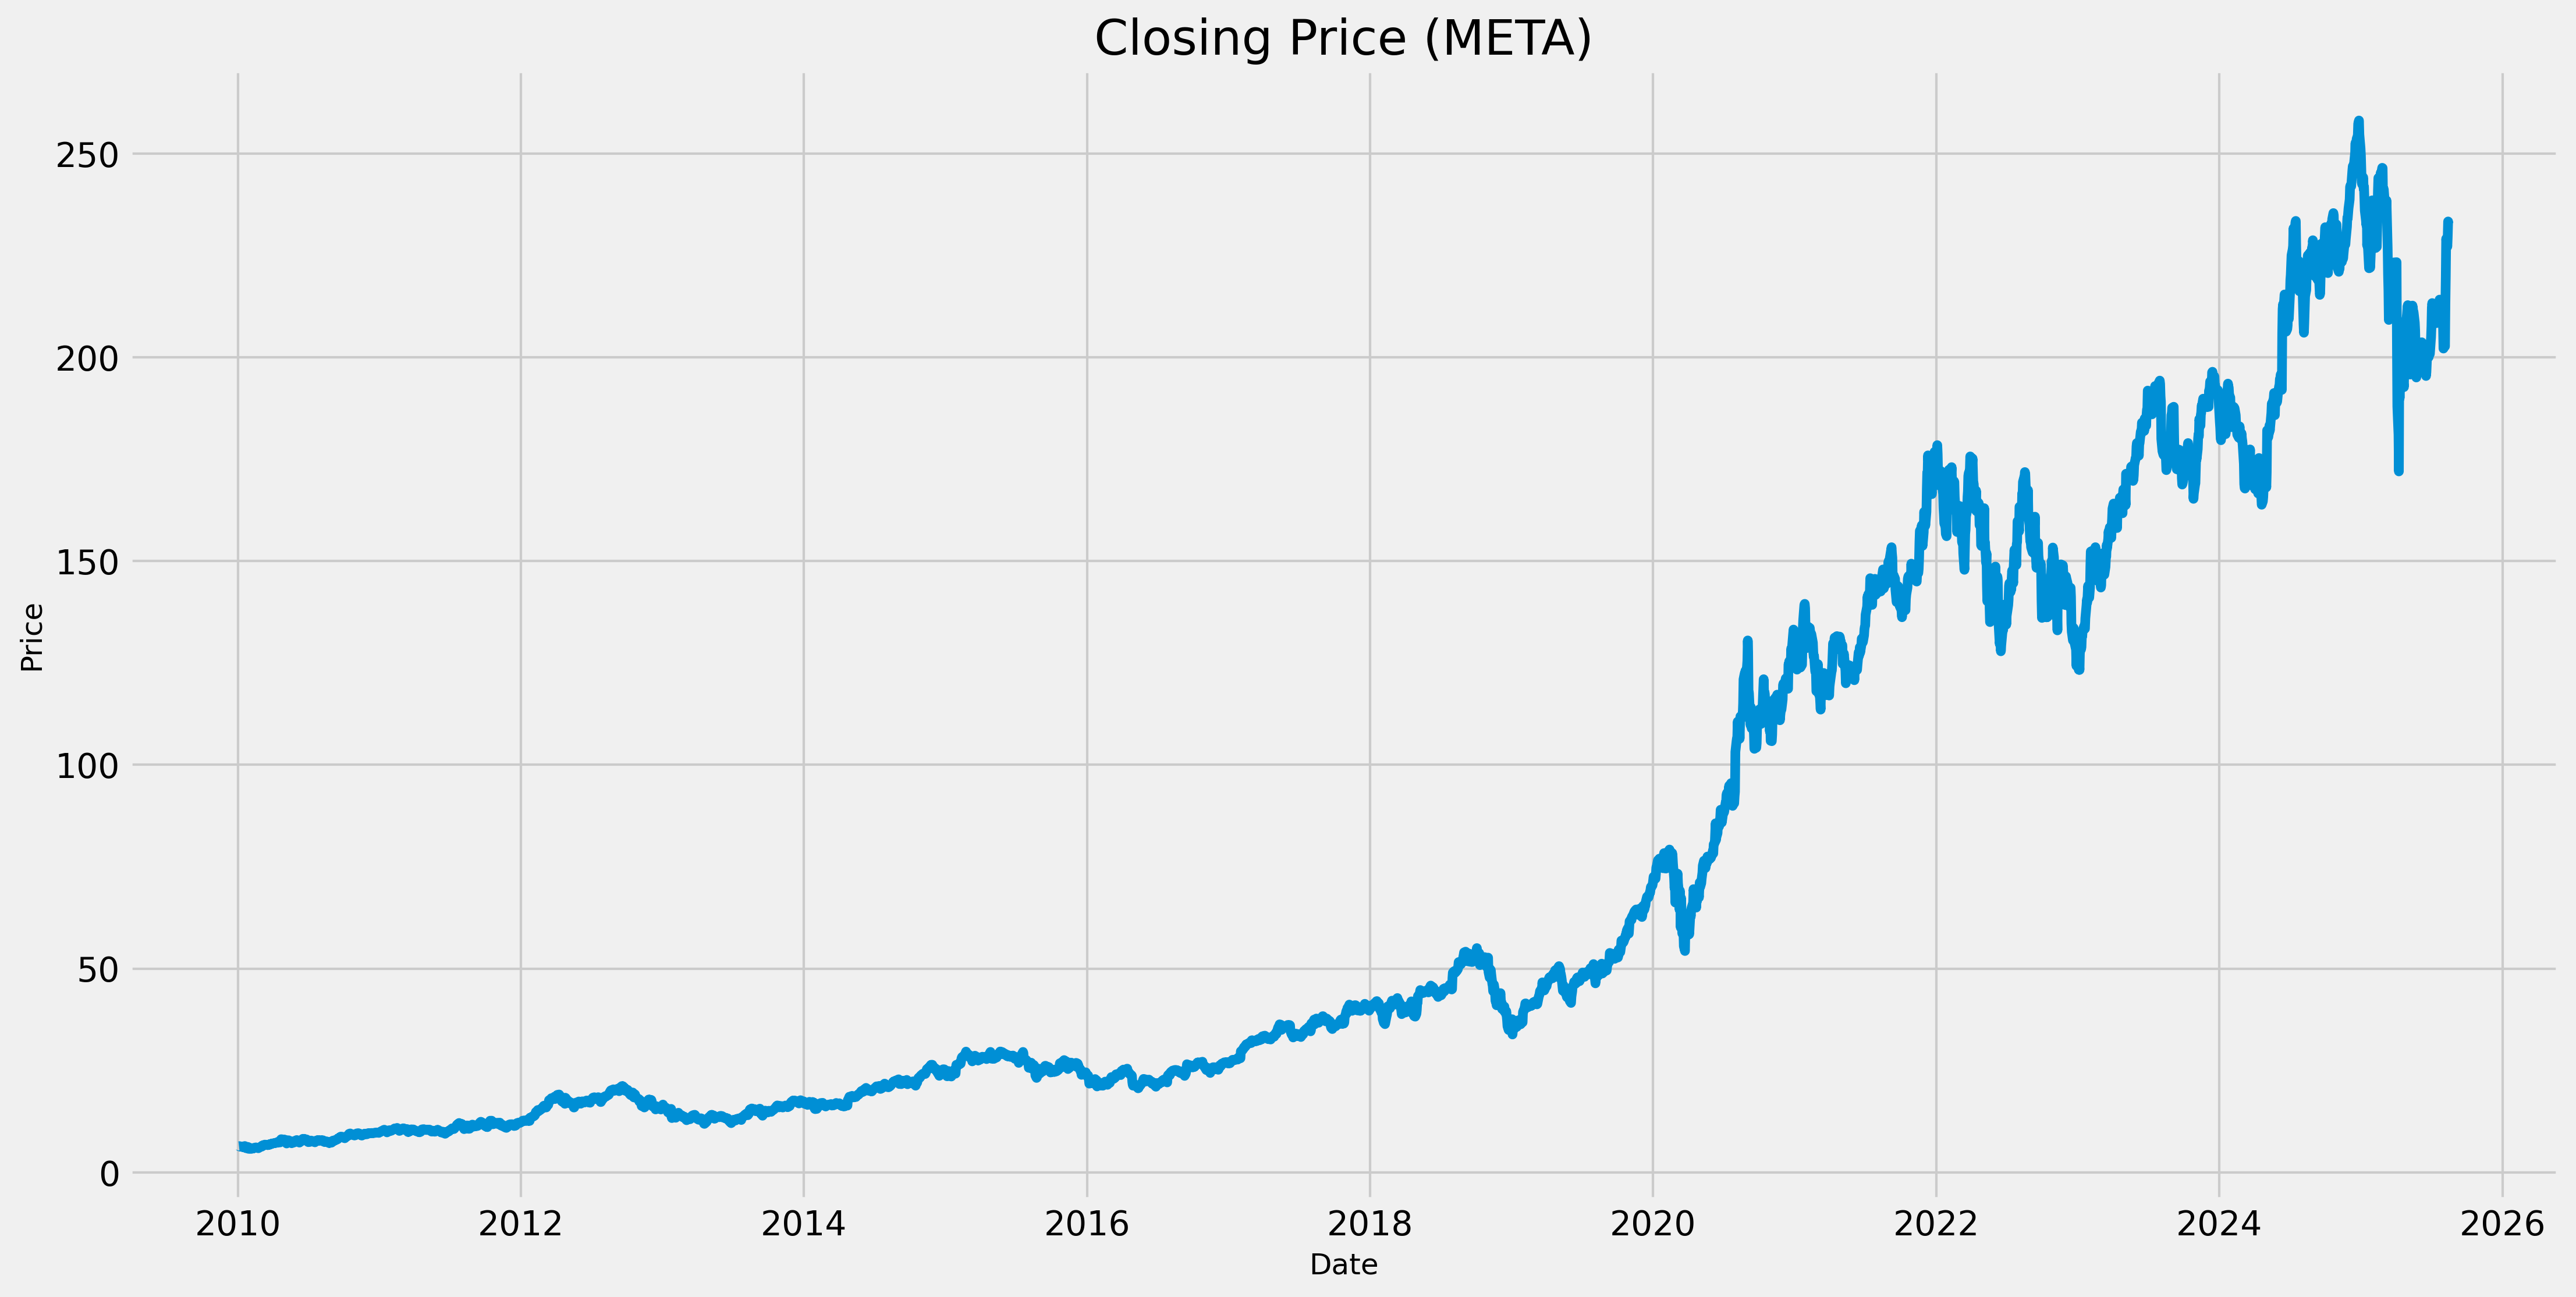

In [22]:
# Plotting the data we recieved onto a graph
plt.figure(figsize=(16,8),dpi=300)
plt.title("Closing Price (META)")
plt.plot(df['Close'])
plt.xlabel('Date',fontsize = 12)
plt.ylabel('Price',fontsize = 12)
plt.show()

In [23]:
df.shape


(3928, 5)

In [24]:
# access the Close price for AAPL
data = df[[('Close', 'AAPL')]]
print(f"Data shape: {data.shape}")

dataset = data.values
training_data_len = math.ceil(len(dataset) * 0.80)

# split the data into training and test
train_data = dataset[0:training_data_len, :]

# create a scaler and FIT it ONLY on the training data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_train_data = scaler.fit_transform(train_data)

x_training = []
y_training = []

for i in range(60, len(scaled_train_data)):
    x_training.append(scaled_train_data[i-60:i, 0])
    y_training.append(scaled_train_data[i, 0])

# convert and reshape for the LSTM model
x_training, y_training = np.array(x_training), np.array(y_training)
x_training = np.reshape(x_training, (x_training.shape[0], x_training.shape[1], 1))

print(f"x_training shape: {x_training.shape}")
print(f"y_training shape: {y_training.shape}")

Data shape: (3928, 1)
x_training shape: (3083, 60, 1)
y_training shape: (3083,)


In [25]:
#building lstm
model = Sequential([
    Input(shape=(x_training.shape[1], 1)),
    LSTM(100, return_sequences=True),
    LSTM(50, return_sequences=False),
    Dense(25, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

In [26]:
#define early stopping
early_stop = EarlyStopping(
    monitor='val_loss',         # track validation loss
    patience=12,                # stop after 12 epochs with no improvement
    restore_best_weights=True   # revert to best model
)

In [27]:
#proper train/validation split for time series
split_idx = int(len(x_training) * 0.8)
x_train = x_training[:split_idx]
y_train = y_training[:split_idx]
x_val = x_training[split_idx:]
y_val = y_training[split_idx:]

model.fit(
   x_train, y_train,
   validation_data=(x_val, y_val),
   epochs=50,
   batch_size=32,
   callbacks=[early_stop],
   verbose=1
)

Epoch 1/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - loss: 0.0017 - val_loss: 0.0023
Epoch 2/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - loss: 1.2309e-04 - val_loss: 0.0016
Epoch 3/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 11s 73ms/step - loss: 3.8600e-05 - val_loss: 0.0020
Epoch 4/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 11s 78ms/step - loss: 3.6190e-05 - val_loss: 0.0016
Epoch 5/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 3.7452e-05 - val_loss: 0.0022
Epoch 6/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - loss: 3.8524e-05 - val_loss: 0.0023
Epoch 7/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 3.9923e-05 - val_loss: 0.0019
Epoch 8/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - loss: 3.1856e-05 - val_loss: 0.0035
Epoch 9/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - loss: 3.2992e-05 - val_loss: 0.0021
Epoch 10/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - loss: 2.9365e-05 - val_loss: 0.0020
Epoch 11/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - loss: 2.4715e-05 - val_loss: 0.0024
Epoch 12/50
78/78 ━

In [28]:
#Testing data set

# test data slice from the original unscaled dataset
test_data = dataset[training_data_len - 60: , :]

y_test = dataset[training_data_len:, :]


x_test_scaled = scaler.transform(test_data)

#x_test sequences from the scaled test data
x_test = []
for i in range (60, len(x_test_scaled)):
  x_test.append(x_test_scaled[i-60:i, 0])

# Convert and reshape
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [29]:
#Print the model's predictions based off of x_test dataset
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


In [30]:
#root mean squared error

rmse = np.sqrt(np.mean((predictions - y_test) ** 2))
print("RMSE = ", rmse)
print("Accuracy = ", 100 - rmse)

RMSE =  6.110942478905686
Accuracy =  93.88905752109432


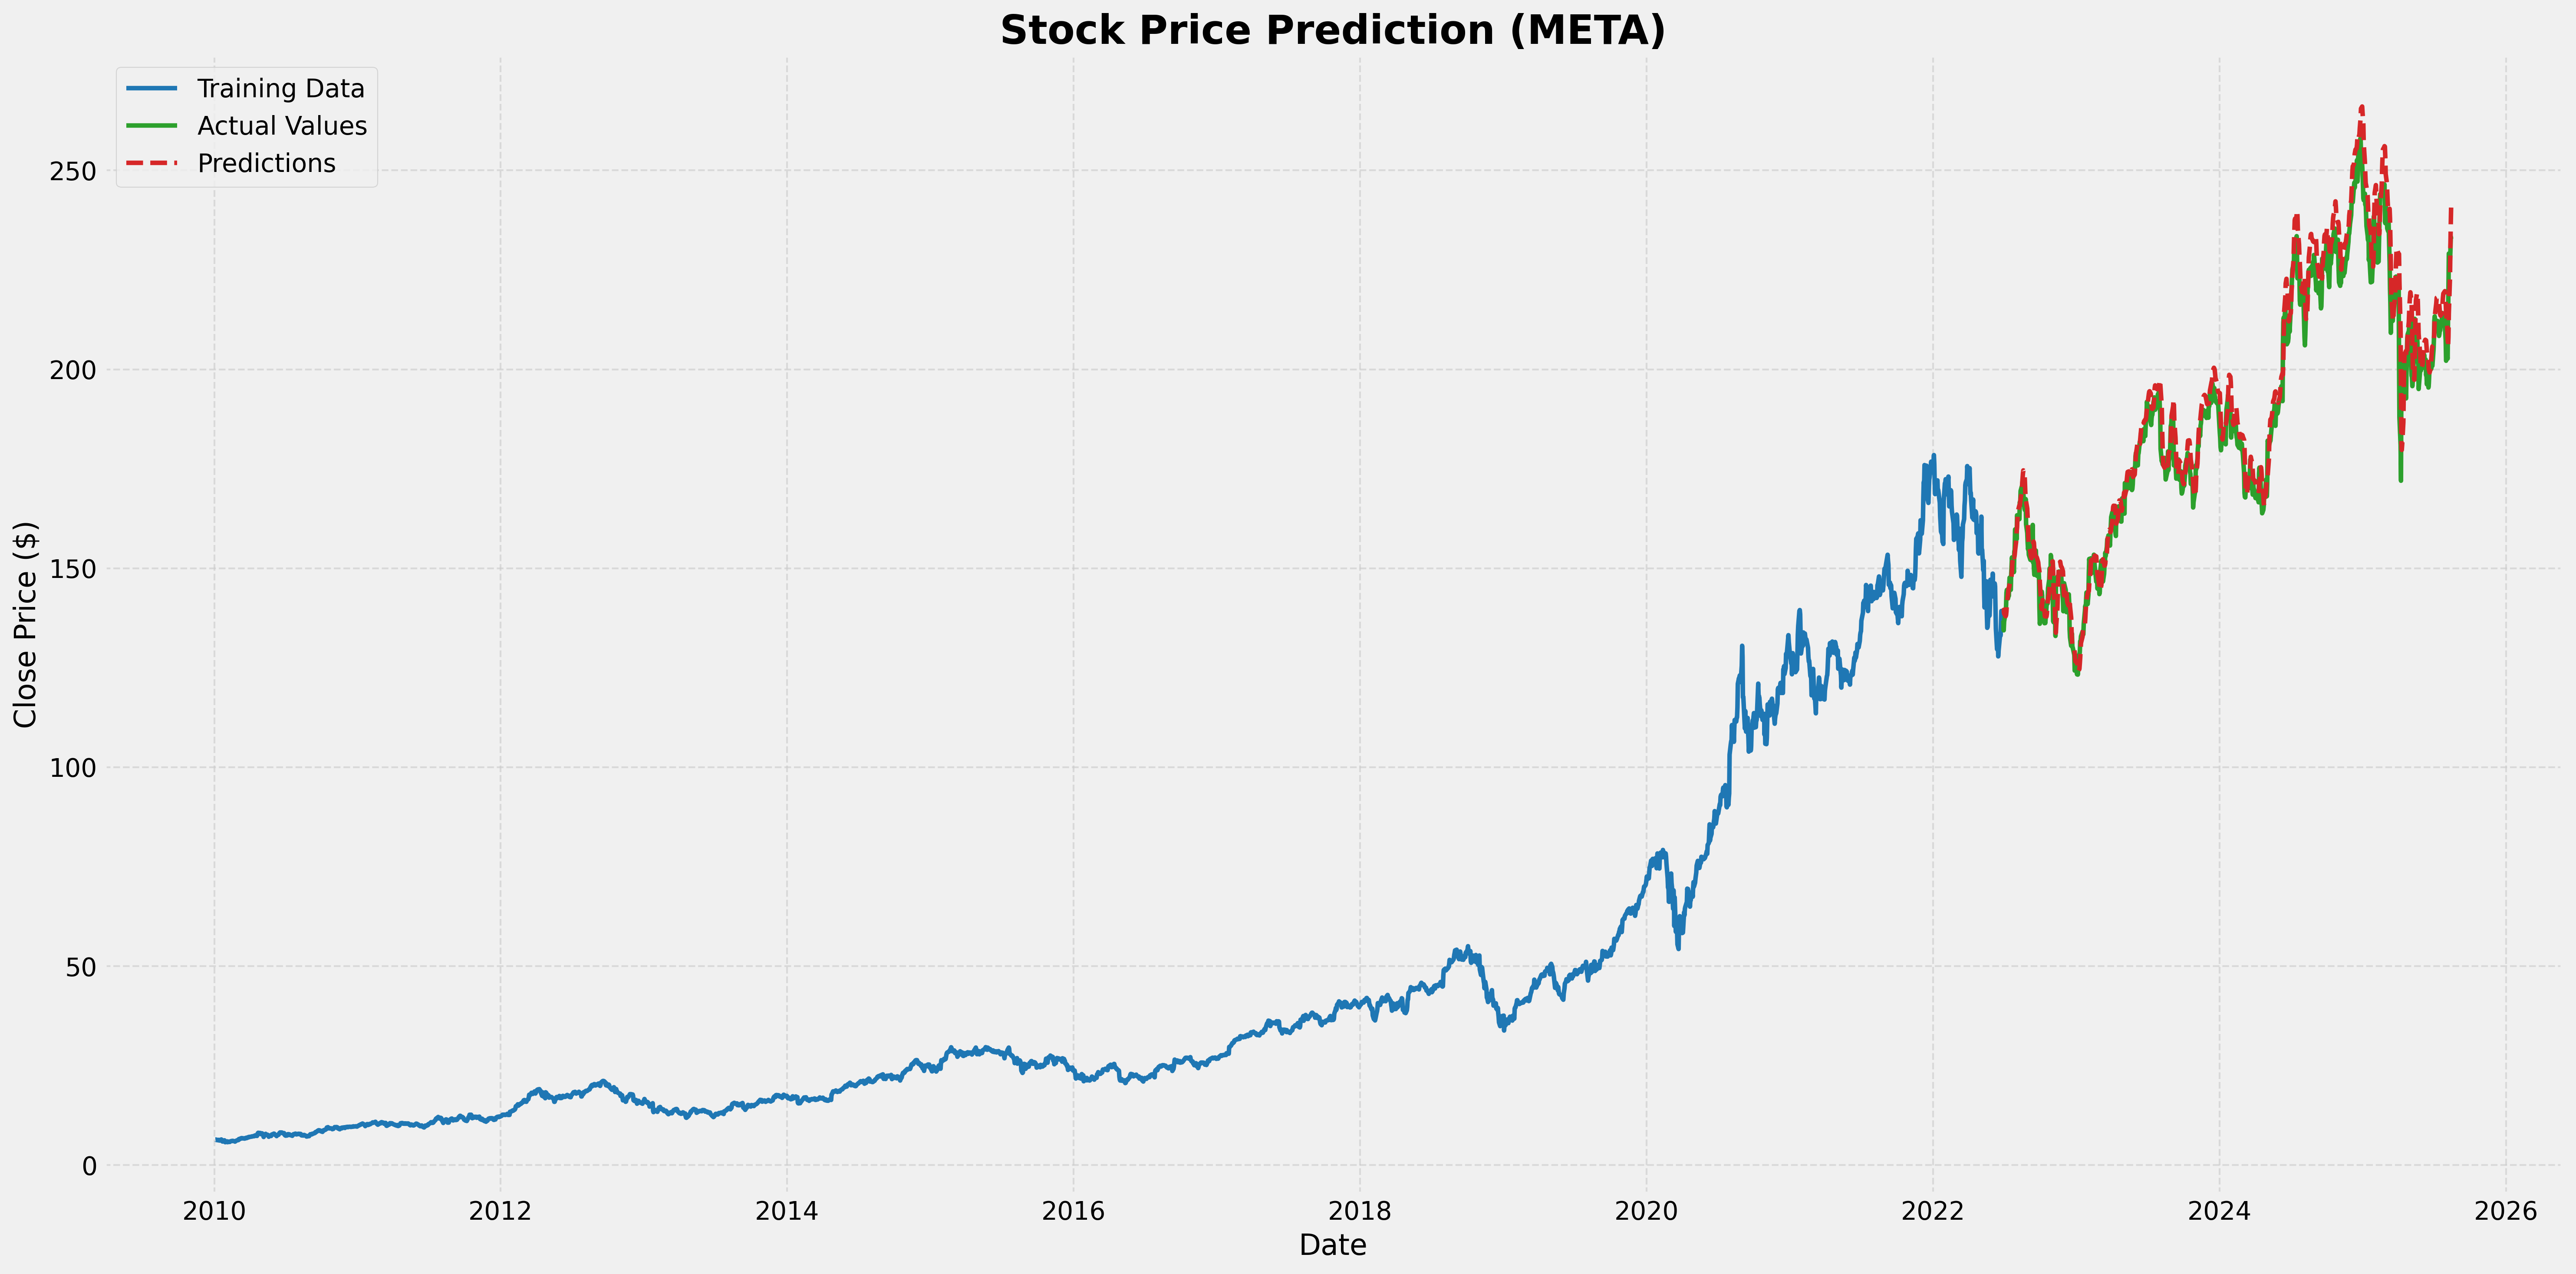

In [31]:
train = data[:training_data_len]
valid = data[training_data_len:].copy()

valid['Predictions'] = predictions

plt.figure(figsize=(20, 10), dpi=300)
plt.title('Stock Price Prediction (META)', fontsize=22, weight='bold')
plt.xlabel('Date', fontsize=16)
plt.ylabel('Close Price ($)', fontsize=16)

# Training data (solid blue)
plt.plot(train.index, train.values, label='Training Data', color='#1f77b4', linewidth=2.5)

# Actual validation data (solid green)
if 'Close' in valid.columns:
    plt.plot(valid.index, valid['Close'], label='Actual Values', color='#2ca02c', linewidth=2.5)
else:
    plt.plot(valid.index, valid.iloc[:, 0], label='Actual Values', color='#2ca02c', linewidth=2.5)

# Predictions (dashed red)
plt.plot(valid.index, valid['Predictions'],
         label='Predictions',
         color='#d62728',
         linestyle='--',
         linewidth=2.5)

# Grid & legend
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=14)
plt.tight_layout()

# Save high-res image
plt.savefig("microsoft_lstm_predictions_clean.png", dpi=300, bbox_inches='tight')
plt.show()


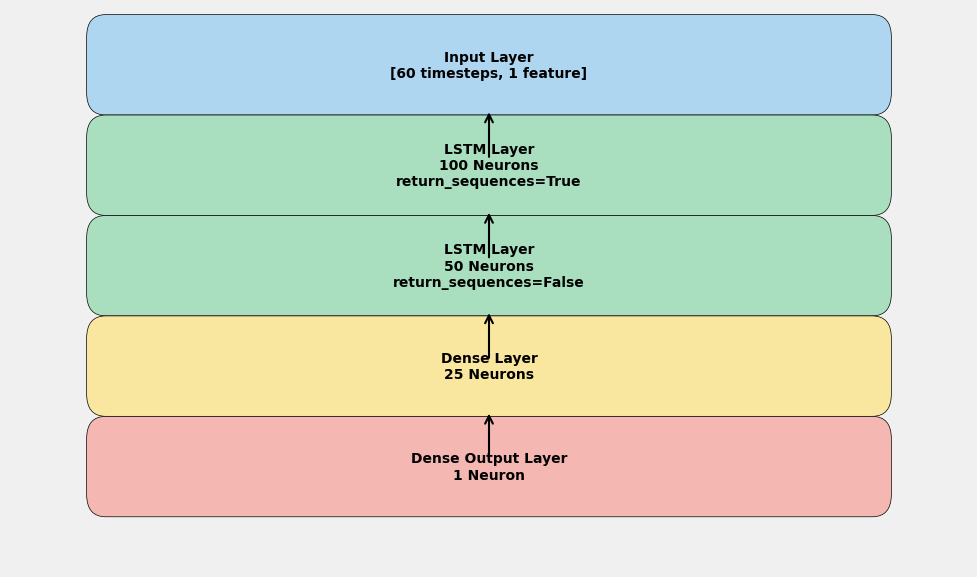

In [32]:
from matplotlib.patches import FancyBboxPatch

def draw_lstm_detailed_architecture():
    fig, ax = plt.subplots(figsize=(10,6))
    ax.axis('off')

    # Layers with neuron info
    layers = [
        ("Input Layer\n[60 timesteps, 1 feature]", "#AED6F1"),
        ("LSTM Layer\n100 Neurons\nreturn_sequences=True", "#A9DFBF"),
        ("LSTM Layer\n50 Neurons\nreturn_sequences=False", "#A9DFBF"),
        ("Dense Layer\n25 Neurons", "#F9E79F"),
        ("Dense Output Layer\n1 Neuron", "#F5B7B1")
    ]

    # Draw each box
    y = 1.0
    for text, color in layers:
        box = FancyBboxPatch(
            (0.1, y-0.15), 0.8, 0.1,
            boxstyle="round,pad=0.02",
            edgecolor="black",
            facecolor=color,
            mutation_aspect=2
        )
        ax.add_patch(box)
        ax.text(0.5, y-0.1, text, ha='center', va='center', fontsize=10, weight='bold')
        y -= 0.18

    # Draw arrows
    y = 1.0 - 0.15
    for _ in range(len(layers)-1):
        ax.annotate("", xy=(0.5, y-0.03), xytext=(0.5, y-0.12),
                    arrowprops=dict(arrowstyle="->", lw=1.5, color='black'))
        y -= 0.18

    plt.tight_layout()
    plt.savefig("lstm_detailed_architecture.png", dpi=300, bbox_inches='tight')
    plt.show()

draw_lstm_detailed_architecture()

In [33]:
valid

Price,Close,Predictions
Ticker,AAPL,
Date,,
2022-06-29,136.876175,139.360840
2022-06-30,134.408661,139.554001
2022-07-01,136.581284,138.602264
2022-07-05,139.166840,137.949966
2022-07-06,140.503830,138.251419
...,...,...
2025-08-08,229.090012,214.027740
2025-08-11,227.179993,223.233627
